# Getting the most solar power for your dollar
## Preprocessing and feature engineering
### Zachary Brown

The data has been cleaned and preliminary analysis has identified some trends we should expect to see the eventual model pick up on. Now I'm going to preprocess the data so that any models I work with can use the data appropriately. This will include imputing missing data, feature engineering, scaling, and splitting the data into testing and training datasets.

I'll start by loading the necessary packages and reading in the data from the exploratory data analysis portion of the project.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme('notebook')
import scipy.stats
from sklearn.model_selection import train_test_split

In [2]:
print(os.getcwd())
os.chdir(r"..\data\processed")
print(os.getcwd())

C:\Users\Zachary Brown\Documents\GitHub\Solar-Panel-Capstone\notebooks
C:\Users\Zachary Brown\Documents\GitHub\Solar-Panel-Capstone\data\processed


In [3]:
data = pd.read_csv('processed_data.csv', index_col=0, na_values = [-1, '-1'], low_memory=False)
data.shape

(208257, 57)

In [4]:
data.columns.groupby(data.dtypes)

{int64: ['expansion_system', 'multiple_phase_system', 'year', 'month', 'state_AZ', 'state_CA', 'state_CO', 'state_CT', 'state_DE', 'state_FL', 'state_MA', 'state_MD', 'state_MN', 'state_NH', 'state_NM', 'state_NY', 'state_RI', 'state_TX', 'state_UT', 'state_WI'], float64: ['system_size_dc', 'total_installed_price', 'rebate_or_grant', 'tracking', 'ground_mounted', 'third_party_owned', 'self_installed', 'azimuth_1', 'tilt_1', 'module_quantity_1', 'additional_modules', 'bipv_module_1', 'bifacial_module_1', 'nameplate_capacity_module_1', 'efficiency_module_1', 'inverter_quantity_1', 'additional_inverters', 'micro_inverter_1', 'solar_storage_hybrid_inverter_1', 'built_in_meter_inverter_1', 'dc_optimizer', 'inverter_loading_ratio', 'price_per_kw'], object: ['data_provider_1', 'system_id_1', 'installation_date', 'customer_segment', 'zip_code', 'city', 'utility_service_territory', 'installer_name', 'module_manufacturer_1', 'module_model_1', 'technology_module_1', 'inverter_manufacturer_1', 'in

I'm going to first remove city since the goal of my project is just to analyze cost efficiency at the state level. Zip code may give some interesting insights on a more granular level, but I don't see additional value in keeping city.

In [5]:
data=data.drop(columns=['city'])

I'm going to check how many zip codes are in the dataset, convert them from 9 digit to 5, and then check to see how many times the top five unique zip codes are present in the dataset.

In [6]:
data['zip_code'].nunique()

7602

In [7]:
data['zip_code'] = data['zip_code'].str[0:5]

In [8]:
print(data['zip_code'].nunique())
data['zip_code'].value_counts().head()

4113


92584    1141
92058    1128
92336    1047
93727     982
95762     908
Name: zip_code, dtype: int64

So it looks like removing the last four digits from the zip code reduced some of the variance, but even so none of the zip codes are used very much relative to the 200,000 entries the dataset has. I'll check how many zip codes have more than 500 entries and then decide on a threshold for which should get dummy columns.

In [9]:
print((data['zip_code'].value_counts() > 500).sum())

43


Right now I have 57 features in my data. A general rule of thumb is to keep the number of features limited to the square root of the number of entries in the data. For this dataset that means I should stick to 456 or fewer features. With that said, I have plenty of room to add 43 dummy columns for specific zip codes and then one other for any zip codes or missing data not included in those 43. Lastly I'll drop the original zip_code column since it will now be redundant.

In [10]:
data['zip_other'] = 0
small_zips = []

for zipcode in data['zip_code'].unique():
    if data['zip_code'].value_counts(dropna=False)[zipcode] > 500:
        data[f'zip_{zipcode}'] = (data['zip_code'] == zipcode)*1
    else:
        small_zips.append(zipcode)
        
data.loc[data['zip_code'].isin(small_zips), 'zip_other'] = 1 
data = data.drop(columns=['zip_code'])
data.shape

(208257, 100)

In [11]:
data.head()

,data_provider_1,system_id_1,installation_date,system_size_dc,total_installed_price,rebate_or_grant,customer_segment,expansion_system,multiple_phase_system,tracking,...,zip_92130,zip_92064,zip_92127,zip_92078,zip_91913,zip_92129,zip_94513,zip_92883,zip_92618,zip_92058
108019,Arizona Public Service,107903,2020-06-17,5.760,17488.26,0.0,RES,0,0,NaN,...,0,0,0,0,0,0,0,0,0,0
108020,Arizona Public Service,107904,2020-06-17,8.750,22631.00,0.0,RES,0,0,NaN,...,0,0,0,0,0,0,0,0,0,0
108142,Arizona Public Service,108026,2020-06-19,4.725,18972.00,0.0,RES,0,0,NaN,...,0,0,0,0,0,0,0,0,0,0
108175,Arizona Public Service,108059,2020-06-22,3.550,9900.00,0.0,RES,0,0,NaN,...,0,0,0,0,0,0,0,0,0,0
108233,Arizona Public Service,108117,2020-06-23,5.850,20475.00,0.0,RES,0,0,NaN,...,0,0,0,0,0,0,0,0,0,0


I want to check each column for the percentage of values that are missing, and remove any features with more than 30% missing values

In [12]:
percent_missing = data.isnull().sum()/len(data)*100
percent_missing.sort_values(ascending=False)

date_of_battery_install    93.650634
ground_mounted             27.698949
azimuth_1                  22.536097
tilt_1                     22.512569
tracking                   21.979573
                             ...    
state_RI                    0.000000
state_NM                    0.000000
state_NH                    0.000000
state_MN                    0.000000
zip_92058                   0.000000
Length: 100, dtype: float64

The only feature that needs to be removed due to null values is 'date_of_battery_install'. 

In [13]:
data=data.drop(columns=['date_of_battery_install'])

Next I want to browse the object columns and count how many unique values each has. If a feature has too many or only one unique value they won't help identify any trends.

In [14]:
for col in data.columns:
    if data[col].dtypes == 'object':
        print(col, ' : ', data[col].nunique())

data_provider_1  :  22
system_id_1  :  200022
installation_date  :  530
customer_segment  :  1
utility_service_territory  :  71
installer_name  :  2640
module_manufacturer_1  :  156
module_model_1  :  2459
technology_module_1  :  6
inverter_manufacturer_1  :  63
inverter_model_1  :  628


Based on these results it should be safe to remove system_id_1, as that has a unique value for almost every entry. I'll also drop customer_segment since earlier in the project I limited the dataset to only residential installations. 

In [15]:
data = data.drop(columns=['system_id_1', 'customer_segment'])

Great! Now I need to encode these categorical features as I did with the states earlier. To do so I'll check the number of entries for each unique value for any feature with more than 30 unique values (anything below 30 I'll just dummy encode like I did with states). If certain values appear in more than 10% of the entries then I'll check to see if they correlate with price per KW when compared against all other values for that feature.

In [16]:
data = pd.get_dummies(data, columns=['technology_module_1', 'data_provider_1'])
data.shape

(208257, 123)

In [17]:
cols = ['installation_date', 'utility_service_territory', 'installer_name', 'module_manufacturer_1',\
        'module_model_1', 'inverter_manufacturer_1', 'inverter_model_1']
for col in cols:
    print(col, ':\n', data[col].value_counts(normalize=True).loc[lambda x : x>0.1], '\n')

installation_date :
 Series([], Name: installation_date, dtype: float64) 

utility_service_territory :
 Pacific Gas and Electric      0.335612
Southern California Edison    0.234652
San Diego Gas and Electric    0.133875
Name: utility_service_territory, dtype: float64 

installer_name :
 Series([], Name: installer_name, dtype: float64) 

module_manufacturer_1 :
 Hanwha Q CELLS    0.247698
SunPower          0.142499
LG Electronics    0.113074
Name: module_manufacturer_1, dtype: float64 

module_model_1 :
 Series([], Name: module_model_1, dtype: float64) 

inverter_manufacturer_1 :
 SolarEdge Technologies    0.460987
Enphase Energy            0.283978
SunPower                  0.118618
Name: inverter_manufacturer_1, dtype: float64 

inverter_model_1 :
 IQ7-60-2-US [240V]    0.129174
SE3800H-US [240V]     0.121405
SE7600H-US [240V]     0.104008
Name: inverter_model_1, dtype: float64 



Based on these distributions I'm going to drop installation_date and installer_name since none of their values account for 10% or more of the entries in the dataset. For the values that do account for at least 10% of the data I'll perform t-tests comparing the price_per_kw for entries with that value vs the rest of the entries. If the p-value of the t-test is less than 0.01 then I'll create a dummy column for it. This includes treating missing data as its own value, since there could be a correlation there as well.

In [18]:
data = data.drop(columns=['installation_date', 'installer_name'])

In [19]:
# Utility service territory: Pacific Gas and Electric
pge = data[data['utility_service_territory'] == 'Pacific Gas and Electric']
not_pge = data[data['utility_service_territory'] != 'Pacific Gas and Electric']
print(scipy.stats.ttest_ind(pge['price_per_kw'], not_pge['price_per_kw']))

Ttest_indResult(statistic=11.85801565604619, pvalue=2.0031706292799543e-32)


In [20]:
data['territory_pacific_gas_and_electric'] = (data['utility_service_territory'] == 'Pacific Gas and Electric')*1

In [21]:
# Utility service territory: Southern California Edison
sce = data[data['utility_service_territory'] == 'Southern California Edison']
not_sce = data[data['utility_service_territory'] != 'Southern California Edison']
print(scipy.stats.ttest_ind(sce['price_per_kw'], not_sce['price_per_kw']))

Ttest_indResult(statistic=-2.2723086588535213, pvalue=0.02306888894162181)


In [22]:
# Utility service territory: San Diego Gas and Electric
sdge = data[data['utility_service_territory'] == 'San Diego Gas and Electric']
not_sdge = data[data['utility_service_territory'] != 'San Diego Gas and Electric']
print(scipy.stats.ttest_ind(sdge['price_per_kw'], not_sdge['price_per_kw']))

Ttest_indResult(statistic=5.735900280612528, pvalue=9.712940594647251e-09)


At this point I'm going to make a copy of the dataframe as a bookmark preceding any data imputation or data loss. My next step will impute missing data as an 'other' category, and after initial modeling I may want to jump back to before this step to rework how I handle those missing data.

In [23]:
no_imputation = data.copy()
no_imputation.to_csv('pre-imputation preprocessing data.csv')

In [24]:
data['territory_san_diego_gas_and_electric'] = (data['utility_service_territory'] == 'San Diego Gas and Electric')*1
data['utility_service_territory_other'] = (~data['utility_service_territory'].isin(['Pacific Gas and Electric',\
                                                                                     'San Diego Gas and Electric']))*1
data=data.drop(columns=['utility_service_territory'])

In [25]:
# Module manufacturer 1: Hanwha Q CELLS
hqc = data[data['module_manufacturer_1'] == 'Hanwha Q CELLS']
not_hqc = data[data['module_manufacturer_1'] != 'Hanwha Q CELLS']
print(scipy.stats.ttest_ind(hqc['price_per_kw'], not_hqc['price_per_kw']))

Ttest_indResult(statistic=-8.214259356889922, pvalue=2.1468194935052494e-16)


In [26]:
data['hanwha_q_cells'] = (data['module_manufacturer_1'] == 'Hanwha Q CELLS')*1

In [27]:
# Module manufacturer 1: SunPower
sp = data[data['module_manufacturer_1'] == 'SunPower']
not_sp = data[data['module_manufacturer_1'] != 'SunPower']
print(scipy.stats.ttest_ind(sp['price_per_kw'], not_sp['price_per_kw']))

Ttest_indResult(statistic=8.007335978228957, pvalue=1.1781773887289662e-15)


In [28]:
data['sunpower'] = (data['module_manufacturer_1'] == 'SunPower')*1

In [29]:
# Module manufacturer 1: Missing
missing = data[data['module_manufacturer_1'].isna()]
not_missing = data[~data['module_manufacturer_1'].isna()]
print(scipy.stats.ttest_ind(missing['price_per_kw'], not_missing['price_per_kw']))

Ttest_indResult(statistic=-6.506949323277298, pvalue=7.686520594864674e-11)


In [30]:
data['module_manufacturer_1_missing'] = (data['module_manufacturer_1'].isna())*1

In [31]:
# Module manufacturer 1: LG Electronics
lg = data[data['module_manufacturer_1'] == 'LG Electronics']
not_lg = data[data['module_manufacturer_1'] != 'LG Electronics']
print(scipy.stats.ttest_ind(lg['price_per_kw'], not_lg['price_per_kw']))

Ttest_indResult(statistic=-5.823115696649686, pvalue=5.784496402514569e-09)


In [32]:
data['lg_electronics'] = (data['module_manufacturer_1'] == 'LG Electronics')*1
data['module_manufacturer_1_other'] = (~data['module_manufacturer_1'].isin(['Hanwha Q CELLS',\
                                                                                     'SunPower', 'LG Electronics', np.NaN]))*1
data=data.drop(columns=['module_manufacturer_1'])

In [33]:
# Module model 1: missing values
missing = data[data['module_model_1'].isna()]
not_missing = data[~data['module_model_1'].isna()]
print(scipy.stats.ttest_ind(missing['price_per_kw'], not_missing['price_per_kw']))

Ttest_indResult(statistic=-6.506949323277298, pvalue=7.686520594864674e-11)


In [34]:
data['module_model_1_missing'] = (data['module_model_1'].isna())*1
data['module_model_1_not_missing'] = (~data['module_model_1'].isna())*1
data = data.drop(columns=['module_model_1'])

In [35]:
# Inverter manufacturer 1: SolarEdge Technologies
se = data[data['inverter_manufacturer_1'] == 'SolarEdge Technologies']
not_se = data[data['inverter_manufacturer_1'] != 'SolarEdge Technologies']
print(scipy.stats.ttest_ind(se['price_per_kw'], not_se['price_per_kw']))

Ttest_indResult(statistic=10.969445074840884, pvalue=5.455545867730912e-28)


In [36]:
data['solaredge_technologies'] = (data['inverter_manufacturer_1'] == 'SolarEdge Technologies')*1

In [37]:
# Inverter manufacturer 1: Enphase Energy
ee = data[data['inverter_manufacturer_1'] == 'Enphase Energy']
not_ee = data[data['inverter_manufacturer_1'] != 'Enphase Energy']
print(scipy.stats.ttest_ind(ee['price_per_kw'], not_ee['price_per_kw']))

Ttest_indResult(statistic=-10.706508488203717, pvalue=9.640694231025681e-27)


In [38]:
data['enphase_energy'] = (data['inverter_manufacturer_1'] == 'Enphase Energy')*1

In [39]:
# Inverter manufacturer 1: Missing
missing = data[data['inverter_manufacturer_1'].isna()]
not_missing = data[~data['inverter_manufacturer_1'].isna()]
print(scipy.stats.ttest_ind(missing['price_per_kw'], not_missing['price_per_kw']))

Ttest_indResult(statistic=-7.509683112556665, pvalue=5.950533690678373e-14)


In [40]:
data['inverter_manufacturer_1_missing'] = (data['inverter_manufacturer_1'].isna())*1

In [41]:
# Inverter manufacturer 1: SunPower
sp = data[data['inverter_manufacturer_1'] == 'SunPower']
not_sp = data[data['inverter_manufacturer_1'] != 'SunPower']
print(scipy.stats.ttest_ind(sp['price_per_kw'], not_sp['price_per_kw']))

Ttest_indResult(statistic=10.464135123265264, pvalue=1.2808671552350103e-25)


In [42]:
data['sunpower'] = (data['inverter_manufacturer_1'] == 'SunPower')*1
data['inverter_manufacturer_1_other'] = (~data['inverter_manufacturer_1'].isin(['SolarEdge Technologies',\
                                                                                     'Enphase Energy', 'SunPower', np.nan]))*1
data=data.drop(columns=['inverter_manufacturer_1'])

In [43]:
# Inverter model 1: Missing
missing = data[data['inverter_model_1'].isna()]
not_missing = data[~data['inverter_model_1'].isna()]
print(scipy.stats.ttest_ind(missing['price_per_kw'], not_missing['price_per_kw']))

Ttest_indResult(statistic=-7.508676624240208, pvalue=5.996442552978743e-14)


In [44]:
data['inverter_model_1_missing'] = (data['inverter_model_1'].isna())*1

In [45]:
# Inverter model 1: IQ7-60-2-US [240V]
iq7 = data[data['inverter_model_1'] == 'IQ7-60-2-US [240V]']
not_iq7 = data[data['inverter_model_1'] != 'IQ7-60-2-US [240V]']
print(scipy.stats.ttest_ind(iq7['price_per_kw'], not_iq7['price_per_kw']))

Ttest_indResult(statistic=-3.284366816056643, pvalue=0.0010222865170599258)


In [46]:
data['iq7'] = (data['inverter_model_1'] == 'IQ7-60-2-US [240V]')*1

In [47]:
# Inverter model 1: SE3800H-US [240V]
se3 = data[data['inverter_model_1'] == 'SE3800H-US [240V]']
not_se3 = data[data['inverter_model_1'] != 'SE3800H-US [240V]']
print(scipy.stats.ttest_ind(se3['price_per_kw'], not_se3['price_per_kw']))

Ttest_indResult(statistic=14.67378142946512, pvalue=1.0038492311428803e-48)


In [48]:
data['se3'] = (data['inverter_model_1'] == 'SE3800H-US [240V]')*1
data['inverter_model_1_other'] = (~data['inverter_model_1'].isin(['IQ7-60-2-US [240V]',\
                                                                                     'SE3800H-US [240V]', np.nan]))*1
data=data.drop(columns=['inverter_model_1'])

In [49]:
print(data.columns.groupby(data.dtypes))

print(data.shape)

{uint8: ['technology_module_1_CIGS', 'technology_module_1_CdTe', 'technology_module_1_Mono', 'technology_module_1_Multi-c-Si', 'technology_module_1_Poly', 'technology_module_1_Thin Film', 'data_provider_1_Arizona Public Service', 'data_provider_1_Austin Energy', 'data_provider_1_CPS Energy', 'data_provider_1_California Public Utilities Commission', 'data_provider_1_Connecticut Green Bank', 'data_provider_1_Delaware Department of Natural Resources and Environmental Control', 'data_provider_1_Frontier Associates', 'data_provider_1_Gainesville Regional Utilities', 'data_provider_1_Los Angeles Department of Water & Power', 'data_provider_1_MA DOER', 'data_provider_1_Maryland Energy Administration', 'data_provider_1_Mohave Electric Cooperative', 'data_provider_1_New Hampshire Public Utilities Commission', 'data_provider_1_New York State Energy Research and Development Authority', 'data_provider_1_Orlando Utilities Commission', 'data_provider_1_Rhode Island Commerce Corporation', 'data_provi

Great! All of the non-numeric features have been converted into dummy features or dropped. 

It's important to note that for utility service territory I've imputed the missing values as 'other'. This may need to be adjusted later on as I work through modeling.

Now the rest of the data imputation and scaling needs to be performed on the training dataset, then applied to the test dataset, so now that all of the desired features have been created I'll split the data into test and train sets. 

In [50]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns='price_per_kw'), data['price_per_kw'], test_size=0.25)

In [51]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(156192, 133) (52065, 133) (156192,) (52065,)


Now I need to check the numeric columns to see if they have -1 for missing data, then decide how best to replace those for the modeling.

In [52]:
for col in X_train.columns:
    if X_train[col].isna().sum() != 0:
        print(col, ' : ', (X_train[col].isna().sum()))

tracking  :  34335
ground_mounted  :  43311
third_party_owned  :  11272
self_installed  :  9494
azimuth_1  :  35206
tilt_1  :  35170
module_quantity_1  :  21764
additional_modules  :  28421
bipv_module_1  :  17052
bifacial_module_1  :  16458
nameplate_capacity_module_1  :  16769
efficiency_module_1  :  18668
inverter_quantity_1  :  21810
additional_inverters  :  28421
micro_inverter_1  :  18055
solar_storage_hybrid_inverter_1  :  26522
built_in_meter_inverter_1  :  18055
dc_optimizer  :  17066
inverter_loading_ratio  :  33120


First I'll work through categorical numerical columns that only have 0/1 categories to check the distributions and determine how best to impute the missing values.

In [53]:
cols = ['self_installed', 'tracking', 'ground_mounted', 'third_party_owned', 'bipv_module_1', 'bifacial_module_1',\
      'additional_inverters', 'additional_modules', 'dc_optimizer', 'micro_inverter_1', 'built_in_meter_inverter_1',\
      'solar_storage_hybrid_inverter_1']
X_train[cols].apply(func = pd.Series.value_counts, args=('normalize', True))

,self_installed,tracking,ground_mounted,third_party_owned,bipv_module_1,bifacial_module_1,additional_inverters,additional_modules,dc_optimizer,micro_inverter_1,built_in_meter_inverter_1,solar_storage_hybrid_inverter_1
0.0,0.982686,0.995921,0.980953,0.651304,0.997506,0.998404,0.999937,0.990624,0.531719,0.529778,0.538552,0.967063
1.0,0.017314,0.004079,0.019047,0.348696,0.002494,0.001596,0.000063,0.009376,0.468281,0.470222,0.461448,0.032937


Many of these columns are heavily skewed, so I'll impute the missing values using the mode and assign the missing values to the more heavily favored response. When I begin modeling I'll compare the model using the imputed results vs removing the columns completely to determine whether I need to reasses how to impute these missing values

In [54]:
X_train[cols] = X_train[cols].fillna(0)
X_test[cols] = X_test[cols].fillna(0)

Now that the categorical numerical features have been taken care of I'll recheck what continuous numerical variables are left to clean up.

In [55]:
cols=[]
for col in X_train.columns:
    if X_train[col].isna().sum() != 0:
        cols.append(col)
        print(col, ' : ', (round(X_train[col].isna().sum()/len(X_train[col]), 2) * 100), '% missing')

azimuth_1  :  23.0 % missing
tilt_1  :  23.0 % missing
module_quantity_1  :  14.000000000000002 % missing
nameplate_capacity_module_1  :  11.0 % missing
efficiency_module_1  :  12.0 % missing
inverter_quantity_1  :  14.000000000000002 % missing
inverter_loading_ratio  :  21.0 % missing


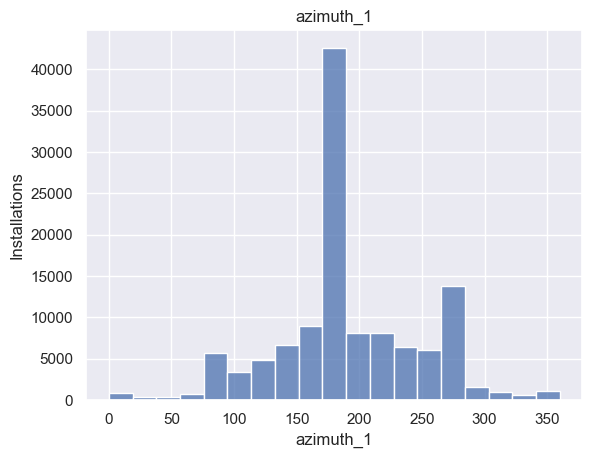

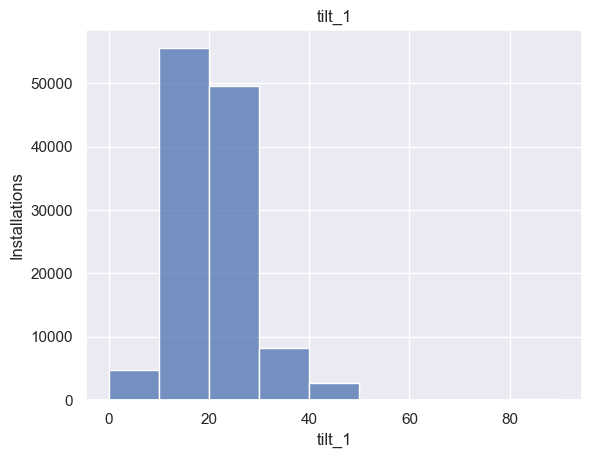

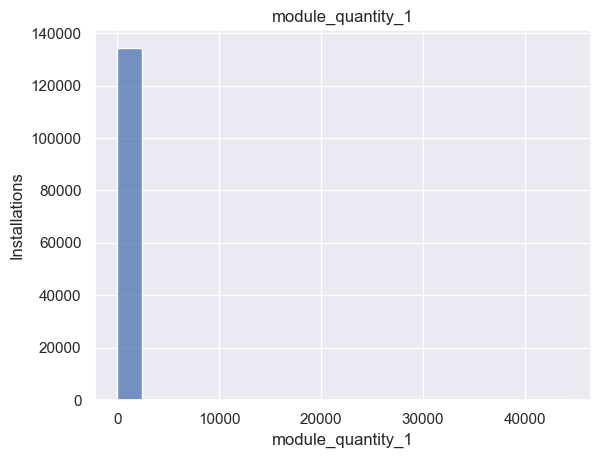

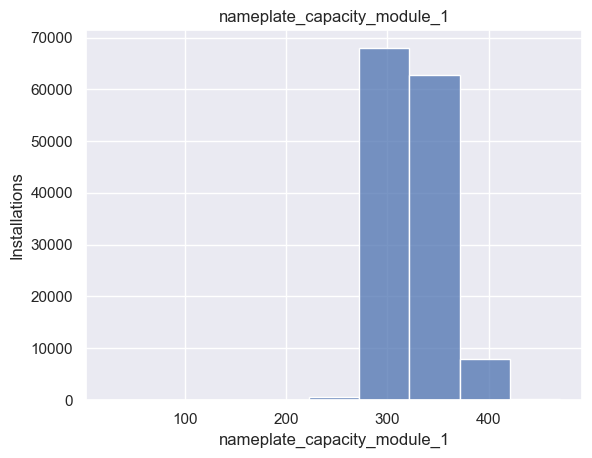

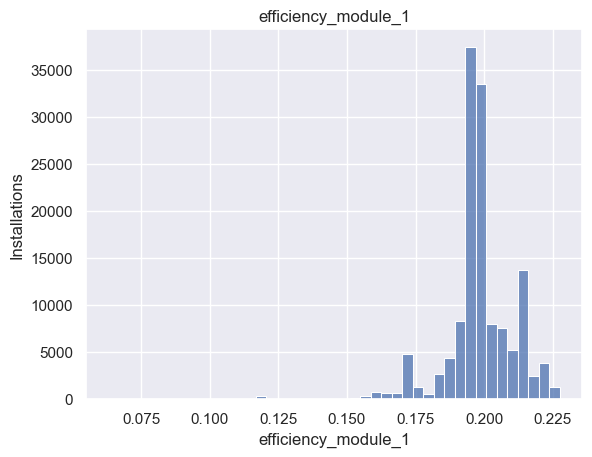

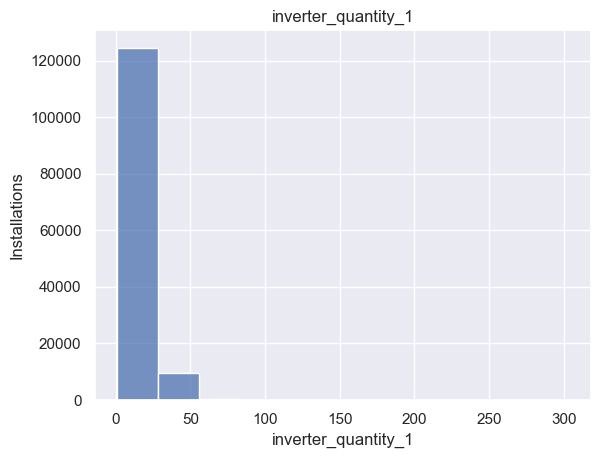

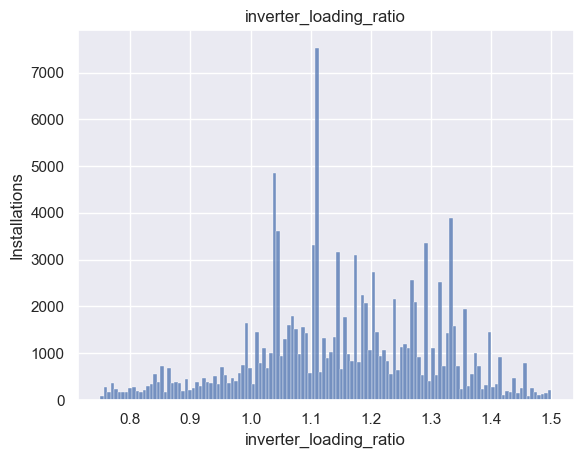

In [56]:
for col in X_train[cols]:
    bins=int(round(np.sqrt(len(data[col].unique()))))
    sns.histplot(data=X_train[col], bins=bins)
    plt.title(col)
    plt.ylabel('Installations')
    plt.xlabel(col)
    plt.show()

In [57]:
X_train['azimuth_1'].value_counts().head()

180.0    30453
270.0     8648
90.0      3276
179.0     1914
181.0     1831
Name: azimuth_1, dtype: int64

Right now my goal is to get a quick first look at some models so that I can determine which features are important and then refine the imputation of any missing data for those features if needed. To that end, I'm going to impute these missing values as the mode for azimuth_1 since it's an angle and there is an obvious preference for one specific angle, and the median for the rest.

In [58]:
from sklearn.impute import SimpleImputer

mode_imputer = SimpleImputer(strategy='most_frequent')

X_train['azimuth_1'] = mode_imputer.fit_transform(X_train['azimuth_1'].values.reshape(-1,1))
X_test['azimuth_1'] = mode_imputer.fit_transform(X_test['azimuth_1'].values.reshape(-1,1))


cols.remove('azimuth_1')

median_imputer = SimpleImputer(strategy='median')

for col in X_train[cols]:
    X_train[col] = median_imputer.fit_transform(X_train[col].values.reshape(-1,1))
    
for col in X_test[cols]:
    X_test[col] = median_imputer.fit_transform(X_test[col].values.reshape(-1,1))

C:\Users\Zachary Brown\anaconda3\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)
C:\Users\Zachary Brown\anaconda3\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this 

Now I'll do one last check of the entire dataframe to confirm that there are no more null values or -1s present, then we should be ready to start modeling.

In [59]:
# Total null values in dataframe
print(X_train.isna().sum().sum())
print(X_test.isna().sum().sum())

0
0


In [60]:
# Total -1 values in dataframe
print((X_train.values == -1).sum())
print((X_test.values == -1).sum())

0
0


Great! Our data looks good to go. I'll export all four portions of data separately for the modeling portion of the project and they can each be read in separately to that notebook.

In [61]:
X_train.to_csv('X_train.csv')
X_test.to_csv('X_test.csv')
y_train.to_csv('y_train.csv')
y_test.to_csv('y_test.csv')